# Set-up

This notebook contains predictive modeling for various distinct target options, namely:

3 Modeling: Binary Classification (**PRICE_BINARY**)
- Binary split is set as a USD Price amount in the Dashboard

4 Modeling: Multi-Class Classification (**PRICE_CLASS**)
- TBD

5 Modeling: Regression (**PRICE_LOG**)
- TBD

**As a consequence, the respective targets need to be selected via the Dashboard BEFORE running the corresponding section.**

## Libraries and Dashboard

In [1016]:
# Import libraries

# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math
import joblib

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, make_pipeline  # Same, but with the latter it is not necessary to name estimator and transformer
#from imblearn.pipeline import Pipeline as Imb_Pipe
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, GenericUnivariateSelect, mutual_info_classif
import eli5

# Predictive Modeling (Models)
from sklearn.dummy import DummyClassifier, DummyRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, NuSVC, SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, PassiveAggressiveRegressor, ElasticNet, SGDRegressor, RANSACRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, VotingClassifier, RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import randint
from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostRegressor

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, fbeta_score, accuracy_score, confusion_matrix, f1_score, precision_recall_curve, recall_score, precision_score, roc_auc_score
from scipy.sparse import csr_matrix
import scipy.stats as stats

# Neural Networks
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [833]:
# Import data_engineered
data = pd.read_pickle(f"saves/{dataset_loc}_{dataset_date}/data_engineered.pkl")

In [834]:
# Feature selection

#... by removing certain features
all_features = [
    el for el in data.columns if el not in [
        'occupancy_rate', 'occupancy_class', 'listing_no', 'price_log', 'price_class',
        'price_binary', "review_scores_class_new", "review_scores_class",
        "review_scores_calc", "neighbourhood_cleansed"
    ]
]

#... by only considering certain features
key_features = [
    "accommodates", "accommodates_per_bed", "am_balcony", "am_breakfast",
    "am_child_friendly", "am_elevator", "am_essentials", "am_pets_allowed",
    "am_private_entrance", "am_smoking_allowed", "am_tv", "availability_90", "bathrooms_log", "bedrooms",
    "calc_host_lst_count_sqrt_log", "cancellation_policy", "host_is_superhost", "instant_bookable",
    "maximum_nights", "minimum_nights_log", "property_type", "room_type", "wk_mth_discount",
    "zipcode"
]

#Display columns:
#all_features
#key_features

In [835]:
# Dashboard (Global Variables)
dataset_loc = "berlin"              # "berlin", "paris", "amsterdam"
dataset_date = "2020-03-17"         # "2019-12-11", "2020-01-10", "2020-02-18", "2020-03-17", "2020-05-14"
target = 'price_log'             # for regression: 'occupancy_rate', 'price_log' | for classification: 'price_class', 'occupancy_class'
binary_split = 50                   # price at which "price_binary" will be split
pred_features = key_features        # select from cell "feature selection" above: [all_features, key_features]
scoring = 'neg_median_absolute_error'  # for regression: 'neg_mean_squared_error', 'r2', 'neg_mean_poisson_deviance', 'neg_median_absolute_error' | for classification: "f1(_micro, _macro, _weighted for multiclass)", "recall", "precision", "accuracy", "roc_auc"
test_size = 0.2
random_state = 42
pd.set_option('display.max_rows', 200)

In [836]:
# Display target and used features
# Print current setting for TARGET
target_upper = target.upper()
print(f"You are currently using \033[1m{target_upper}\033[0m as the target and \033[1m{scoring}\033[0m for scoring to predict prices for \033[1m{dataset_loc}\033[0m on \033[1m{dataset_date}\033[0m\n")
print(f"You are currently using these features for its prediction:\n\033[1m{pred_features}\033[0m\n")

if target in pred_features:
    print(f"WARNING: You are using \033[1m{target_upper}\033[0m as predictor. Please remove before proceeding.\n")

if target == 'price_binary':
    if 'price_class' in pred_features:
        print(f"WARNING: Please remove \033[1m'price_class'\033[0m from features before proceeding with target \033[1m{target_upper}\033[0m")
    if 'price_log' in pred_features:
        print(f"WARNING: Please remove \033[1m'price_log'\033[0m from features before proceeding with target \033[1m{target_upper}\033[0m")

if target == 'price_class':
    if 'price_binary' in pred_features:
        print(f"WARNING: Please remove \033[1m'price_binary'\033[0m from features before proceeding with target \033[1m{target_upper}\033[0m")
    if 'price_log' in pred_features:
        print(f"WARNING: Please remove \033[1m'price_log'\033[0m from features before proceeding with target \033[1m{target_upper}\033[0m")

if target == 'price_log':
    if 'price_class' in pred_features:
        print(f"WARNING: Please remove \033[1m'price_class'\033[0m from features before proceeding with target \033[1m{target_upper}\033[0m")
    if 'price_binary' in pred_features:
        print(f"WARNING: Please remove \033[1m'price_binary'\033[0m from features before proceeding with target \033[1m{target_upper}\033[0m")
        
if "occupancy_class" in pred_features and "occupancy_rate" in pred_features:
    print(f"WARNING: Please remove \033[1m'ocupancy_class'\033[0m or \033[1m'ocupancy_rate'\033[0m from features before proceeding with target \033[1m{target_upper}\033[0m")

else:
    print("No issues with your selection of pred_features have been detected. Please make sure to manually check for correctness nevertheless.")
          

You are currently using PRICE_LOG as the target and neg_median_absolute_error for scoring to predict prices for berlin on 2020-03-17

You are currently using these features for its prediction:
['accommodates', 'accommodates_per_bed', 'am_balcony', 'am_breakfast', 'am_child_friendly', 'am_elevator', 'am_essentials', 'am_pets_allowed', 'am_private_entrance', 'am_smoking_allowed', 'am_tv', 'availability_90', 'bathrooms_log', 'bedrooms', 'calc_host_lst_count_sqrt_log', 'cancellation_policy', 'host_is_superhost', 'instant_bookable', 'maximum_nights', 'minimum_nights_log', 'property_type', 'room_type', 'wk_mth_discount', 'zipcode']

No issues with your selection of pred_features have been detected. Please make sure to manually check for correctness nevertheless.


## Global Functions and Variables

In [837]:
# Create "price_binary" at given split
price_binary = []
for price in data.price_log:
    if math.exp(price) <= binary_split:
        price_binary.append(1)
    else:
        price_binary.append(2)
data["price_binary"] = price_binary

In [838]:
# "mean_absolute_percentage_error": Function for mean absolute percentage error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [839]:
# "median_absolute_percentage_error": Function for median absolute percentage error (MAPE median)
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

In [840]:
# "print_target_setting": Function for printing current setting for TARGET and the corresponding features
def print_target_setting():
    target_upper = target.upper()
    y_upper = y_train.name.upper()
    print(f"You are currently using \033[1m{target_upper}\033[0m as the target and \033[1m{scoring}\033[0m for scoring to predict prices for \033[1m{dataset_loc}\033[0m on \033[1m{dataset_date}\033[0m\n")
    print(f"The target variable y is set to \033[1m{y_upper}\033[0m\n")
    print(f"You are currently using these features for its prediction:\n\033[1m{pred_features}\033[0m\n")

In [930]:
# "get_feat_importances": Function for retrieving feature importances
def get_feat_importances(model, column_names=column_names):
    model=model
    feat_importances = pd.DataFrame(model.feature_importances_,
                 columns=['weight'],
                 index=column_names)
    feat_importances.sort_values('weight', inplace=True, ascending=False)
    return feat_importances

In [842]:
# "model_eval": Function for final evaluation of "best model"
def model_eval(y, y_pred, model="reg"):
    """
    Please always specify the type of model:
    Regression: model="reg"
    Binary Classification: model="bclf"
    Multiclass Classification: model="clf"
    """
    if model=="reg":
        print("MSE: {:.2f}".format(mean_squared_error(y, y_pred)))
        print("RMSE: {:.2f}".format(
        mean_squared_error(y, y_pred, squared=False)))
        print("MAE: {:.2f}".format(mean_absolute_error(y, y_pred)))
        print("R2: {:.2f}".format(r2_score(y, y_pred)))
        print("MAPE: {:.2f}".format(mean_absolute_percentage_error(y, y_pred)))
        print("MAPE median: {:.2f}".format(median_absolute_percentage_error(y, y_pred)))

    elif model=="bclf":
        print("Accuracy: {:.2f}".format(accuracy_score(y, y_pred)))
        print("Recall: {:.2f}".format(recall_score(y, y_pred)))
        print("Precision: {:.2f}".format(precision_score(y, y_pred)))
        print("F1 Score: {:.2f}".format(f1_score(y, y_pred)))
        print("ROC/AUC: {:.2f}".format(roc_auc_score(y, y_pred)))
        print("Confusion Matrix: \n" + str(confusion_matrix(y, y_pred)))

    elif model=="clf":
        print("Accuracy: {:.2f}".format(accuracy_score(y, y_pred)))
        print("Recall: {:.2f}".format(recall_score(y, y_pred, average='weighted')))
        print("Precision: {:.2f}".format(precision_score(y, y_pred, average='weighted')))
        print("F1 Score: {:.2f}".format(f1_score(y, y_pred, average='weighted')))
        print("Confusion Matrix: \n" + str(confusion_matrix(y, y_pred)))
    
    else:
        print("Please revise your parameters (e.g. provide a valid model).")

In [884]:
# "save_model": Function for saving model (pickle or joblib)
def save_model(model, title="unknown", save="joblib"):
    if save=="joblib":
        joblib.dump(model, f"saves/{dataset_loc}_{dataset_date}/{title}.pkl")
    elif save=="pickle":
        model.to_pickle(f"saves/{dataset_loc}_{dataset_date}/{title}.pkl")
#        save also evaluation (from y_test, y_train)

In [891]:
# "load_model": Function for loading model (pickle or joblib)
def load_model(title="unknown", dataset_loc=dataset_loc, dataset_date=dataset_date, load="joblib"):
    if load=="joblib":
        return joblib.load(f"saves/{dataset_loc}_{dataset_date}/{title}.pkl")

In [845]:
# "clf_learning_curves": Function to evaluate classification model based on learning curves
def clf_learning_curves(model):
# Fit model on training data
    model = model
    eval_set = [(X_train_prep, y_train), (X_test_prep, y_test)]
    model.fit(X_train_prep, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

    # Make predictions for test data
    y_pred = model.predict(X_test_prep)
    predictions = [round(value) for value in y_pred]

    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    # Retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    
    # Plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()
    
    # Plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()

# Preprocessing (Train/Test Split and Pipeline)

In [846]:
# Drop columns
drop_columns = [el for el in data.columns if el not in pred_features]
drop_columns.remove(target)
data.drop(labels=drop_columns, inplace=True, axis=1)

In [847]:
# Drop rows (optional, just temporary)
#data = data[data.number_of_reviews_ltm_log>1.7]

## Preprocessing pipeline

In [848]:
# Create list for categorical predictors/features (used in "Scaling with Preprocessing Pipeline")
cat_features = list(data.columns[data.dtypes == object])
#cat_features.remove("neighbourhood")
#cat_features.remove("zipcode")
cat_features

['cancellation_policy', 'property_type', 'room_type', 'zipcode']

In [849]:
# Create list for numerical predictors/features (removing target column, used in "Scaling with Preprocessing Pipeline")
num_features = list(data.columns[data.dtypes != object])
num_features.remove(target)
num_features

['accommodates',
 'accommodates_per_bed',
 'am_balcony',
 'am_breakfast',
 'am_child_friendly',
 'am_elevator',
 'am_essentials',
 'am_pets_allowed',
 'am_private_entrance',
 'am_smoking_allowed',
 'am_tv',
 'availability_90',
 'bathrooms_log',
 'bedrooms',
 'calc_host_lst_count_sqrt_log',
 'host_is_superhost',
 'instant_bookable',
 'maximum_nights',
 'minimum_nights_log',
 'wk_mth_discount']

In [850]:
# Build preprocessor pipeline
# Pipeline for numerical features
num_pipeline = Pipeline([('imputer_num', SimpleImputer(strategy='median')),
                         ('std_scaler', StandardScaler())])

# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(drop='first', handle_unknown='error'))
])

# Complete pipeline
preprocessor = ColumnTransformer([('num', num_pipeline, num_features),
                                  ('cat', cat_pipeline, cat_features)])

## Train/test split

In [851]:
# Define predictors and target variable
X = data.drop([target], axis=1)
y = data[target]

In [852]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=random_state,
                                                    shuffle=True)
#                                                   stratify=y) # Use stratify=y if labels are inbalanced (e.g. most wines are 5 or 6; check with value_counts()!)

In [853]:
# Saving preprocessed X_train and X_test
X_train_prep_preprocessor = preprocessor.fit(X_train)

X_train_prep = X_train_prep_preprocessor.transform(X_train)
X_train_num_prep = num_pipeline.fit_transform(X_train[num_features])
X_test_prep = X_train_prep_preprocessor.transform(X_test)

In [854]:
# Get feature names from pipeline after one-hot encoding as "column_names"
onehot_columns = list(preprocessor.named_transformers_['cat']['1hot'].get_feature_names(cat_features))
column_names = num_features + onehot_columns

## Outlier Detection

In [216]:
# Preprocess data
train_outl = num_pipeline.fit_transform(X_train[num_features], y_train)

In [217]:
# Fit DBSCAN model
outl_model = DBSCAN(eps=3.0, min_samples=10).fit(train_outl)
outl_labels = outl_model.labels_

In [218]:
# Display results (# of outliers)
pd.Series(outl_labels).value_counts()

0    8456
1      34
dtype: int64

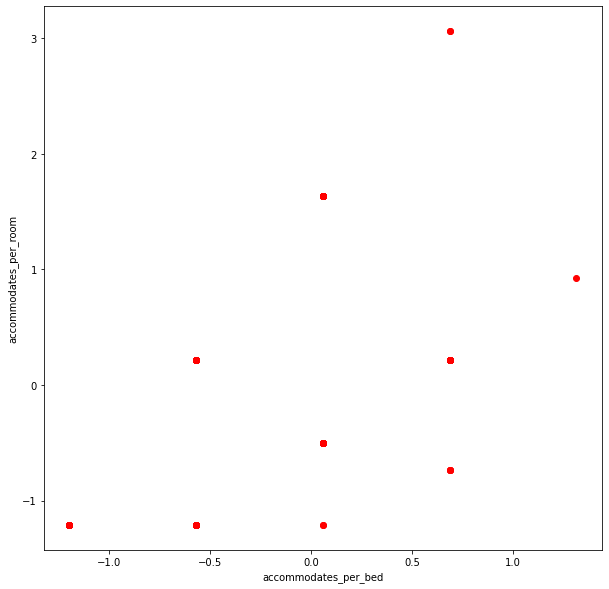

In [55]:
# Illustrate results
plt.figure(figsize=(10,10))

unique_labels = set(outl_labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in outl_labels]
    plt.plot(train_outl[:,0][sample_mask], train_outl[:, 1][sample_mask], 'o', color=color);
plt.xlabel('accommodates_per_bed');
plt.ylabel('accommodates_per_room');

Interpreting the results:

- https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate
- https://datascience.stackexchange.com/questions/46092/how-do-we-interpret-the-outputs-of-dbscan-clustering

## Perform Feature Selection (add most useful to modeling pipeline)

In [18]:
# Set X_fs to desired variable
X_fs = X_train[
    num_features]  # X_train_prep, X_train_num_prep, X_train[num_features]
#X_fs = pd.DataFrame(X_fs, columns = X_train_prep_cols)

**GenericUnivariateSelect** (Classification and Regression)

In [19]:
# Apply GenericUnivariateSelect
trans_GUS = GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0),
                                    mode='k_best',
                                    param=15)  #mode='percentile', 'k_best'
X_train_GUS = trans_GUS.fit_transform(X_fs, y_train)

**mutual_info_classif** (Classification)

In [20]:
# Fit mutual_info_classif
#X_train_mic = mutual_info_classif(X_fs, y_train)

In [21]:
# Plot feature importance
#plt.subplots(1, figsize=(26, 1))
#sns.heatmap(X_train_mic[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
#plt.yticks([], [])
#plt.gca().set_xticklabels(X_fs.columns, rotation=45, ha='right', fontsize=12)
#plt.suptitle("Feature Importance (mutual_info_classif)", fontsize=18, y=1.2)
#plt.gcf().subplots_adjust(wspace=0.2)
#pass

In [22]:
# Apply GenericUnivariateSelect to reduce features (optional)
#trans_mic = GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=15) #mode='percentile', 'k_best',
#X_train_mic_GUS = trans_mic.fit_transform(X_fs, y_train)

In [23]:
# Print kept features
#print("We started with {0} features but retained only {1} of them!".format(
#    X_fs.shape[1] - 1, X_train_mic_GUS.shape[1]))

#columns_retained_Select = X_fs.columns[trans_mic.get_support()].values
#pd.DataFrame(X_train_mic_GUS, columns=columns_retained_Select).head()

**chi2** (Classification)

**mutual_info_regression** (Regression)

# Modeling: Binary Classification ("price_binary")

## Apply Classification Models

In [277]:
# Print current setting for TARGET
print_target_setting()
print(f"Binary Split:  \033[1mUSD {binary_split}\033[0m")

You are currently using PRICE_BINARY as the target and roc_auc for scoring to predict prices for berlin on 2020-03-17

The target variable y is set to PRICE_BINARY

You are currently using these features for its prediction:
['accommodates', 'bathrooms_log', 'host_is_superhost', 'property_type', 'room_type', 'zipcode']

Binary Split:  USD 50


In [278]:
# Select models for comparison
models = {
    'Baseline':
    DummyClassifier(strategy='most_frequent'),
    'LogReg':
    LogisticRegression(max_iter=1000),
    'KNN':
    KNeighborsClassifier(),
    'SVC':
    SVC(kernel='rbf', C=1E6),
    'Decision Tree':
    DecisionTreeClassifier(criterion="gini",
                           max_depth=3,
                           random_state=random_state),
    'Random Forest':
    RandomForestClassifier(random_state=random_state,
                           max_features='sqrt',
                           n_jobs=-1),
    'Gradient Boost':
    GradientBoostingClassifier(random_state=random_state),
    'XGBoost':
    XGBClassifier(),
    'AdaBoost':
    AdaBoostClassifier(random_state=random_state)
}

In [279]:
# Calculate and display results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'ROC/AUC'])
i = 0
for m in models.items():
    # Building a full pipeline with our preprocessor and a Classifier
    pipe = Pipeline([('preprocessor', preprocessor), (m[0], m[1])])
    # Making predictions on the training set using cross validation as well as calculating the probabilities
    y_train_pred = cross_val_predict(pipe,
                                     X_train,
                                     y_train.values.ravel(),
                                     cv=5,
                                     verbose=4,
                                     n_jobs=-1)
    # Calculating metrices
    temp = pd.DataFrame(
        {
            'Model': m[0],
            'Accuracy': accuracy_score(y_train, y_train_pred),
            'Recall': recall_score(y_train, y_train_pred, average="weighted"),
            'Precision': precision_score(
                y_train, y_train_pred, average="weighted"),
            'F1 Score': f1_score(y_train, y_train_pred, average="weighted"),
            'ROC/AUC': roc_auc_score(y_train, y_train_pred)
        },
        index=[i])
    print(f"Confusion Matrix {m[0]}: \n" +
          str(confusion_matrix(y_train, y_train_pred)))
    i += 1
    results = pd.concat([results, temp])
results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Baseline: 
[[   0 3993]
 [   0 4497]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix LogReg: 
[[2941 1052]
 [ 793 3704]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix KNN: 
[[2837 1156]
 [ 962 3535]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix SVC: 
[[2926 1067]
 [ 938 3559]]
Confusion Matrix Decision Tree: 
[[2775 1218]
 [ 693 3804]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Random Forest: 
[[2906 1087]
 [ 867 3630]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Gradient Boost: 
[[2871 1122]
 [ 666 3831]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix XGBoost: 
[[2860 1133]
 [ 667 3830]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s


Confusion Matrix AdaBoost: 
[[2904 1089]
 [ 792 3705]]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


,Model,Accuracy,Recall,Precision,F1 Score,ROC/AUC
0,Baseline,0.529682,0.529682,0.280563,0.366825,0.500000
1,LogReg,0.782686,0.782686,0.782955,0.782085,0.780100
2,KNN,0.750530,0.750530,0.750375,0.750058,0.748286
3,SVC,0.763840,0.763840,0.763656,0.763571,0.762099
4,Decision Tree,0.774912,0.774912,0.777552,0.773200,0.770432
5,Random Forest,0.769847,0.769847,0.769864,0.769335,0.767489
6,Gradient Boost,0.789399,0.789399,0.791453,0.788104,0.785455
7,XGBoost,0.787986,0.787986,0.790136,0.786639,0.783966
8,AdaBoost,0.778445,0.778445,0.778896,0.777707,0.775578


## Clf Model 1: Logistic Regression

In [280]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_lr_bclf = Pipeline([('preprocessor', preprocessor),
                            ('lr_bclf',
                             LogisticRegression(penalty='l2',
                                                max_iter=100,
                                                C=0.9,
                                                random_state=random_state,
                                                l1_ratio=0.5,
                                                n_jobs=-1))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [281]:
# Display possible hyperparameters for LogisticRegression
test_lr_bclf = LogisticRegression()
test_lr_bclf.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

**Default values for LogisticRegression** (as base for hyperparameter search):

penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None,

In [283]:
# Define hyperparameter distribution
param_distribs_lr_bclf = {
    'lr_bclf__penalty': ['l1', 'l2'],
    'lr_bclf__max_iter': randint(low=10, high=100),
    'lr_bclf__C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    'lr_bclf__l1_ratio': [None, 0.1, 0.2, 0.3, 0.5, 0.9, 1]
}

In [284]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_lr_bclf = RandomizedSearchCV(pipeline_lr_bclf,
                                 param_distribs_lr_bclf,
                                 cv=5,
                                 scoring=scoring,
                                 n_iter=50,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_lr_bclf = rnd_lr_bclf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


In [285]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_lr_bclf.best_score_))
print("Best parameters:\n{}".format(rnd_lr_bclf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.85
Best parameters:
{'lr_bclf__C': 20, 'lr_bclf__l1_ratio': 0.1, 'lr_bclf__max_iter': 83, 'lr_bclf__penalty': 'l2'}


### Hyperparameter Tuning with GridSearchCV

In [289]:
# Define hyperparameter grid
param_grid_lr_bclf = {
    'lr_bclf__penalty': ['l1', 'l2'],
    'lr_bclf__max_iter': [100, 125, 150, 200],
    'lr_bclf__C': [10, 20, 30],
    'lr_bclf__l1_ratio': [None, 0.05, 0.1]
}

In [307]:
# Create and fit GridSearchCV, save "best_model"
grid_lr_bclf = GridSearchCV(pipeline_lr_bclf,
                            param_grid_lr_bclf,
                            cv=5,
                            scoring=scoring,
                            return_train_score=True,
                            verbose=4,
                            n_jobs=-1)

grid_lr_bclf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.9s finished


In [ ]:
# Save best model
best_model_lr_bclf = grid_lr_bclf.best_estimator_['lr_bclf']

In [291]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_lr_bclf.best_score_))
print("Best parameters:\n{}".format(grid_lr_bclf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.85
Best parameters:
{'lr_bclf__C': 20, 'lr_bclf__l1_ratio': None, 'lr_bclf__max_iter': 150, 'lr_bclf__penalty': 'l2'}


### Feature Importances

In [294]:
# Get and print feature importances
#grid_lr_bclf_fi = feat_importances(grid_lr_bclf, cv_model=True, named_steps='lr_bclf', column_names=column_names)
#grid_lr_bclf_fi

### !!! Model Evaluation

In [ ]:
# Predict target with "best model"
y_train_pred_lr_bclf = best_model_lr_bclf.predict(X_train_prep)

In [ ]:
# Final evaluation with "best model"
model_eval(y_train, y_train_pred_lr_bclf, model="bclf"):

In [567]:
# Calculating the accuracy, recall and precision for the test set with the best model
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_pred_lr_bclf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_pred_lr_bclf)))
print("Precision: {:.2f}".format(precision_score(y_train, y_pred_lr_bclf)))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_pred_lr_bclf)))
print("ROC/AUC: {:.2f}".format(roc_auc_score(y_train, y_pred_lr_bclf)))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_pred_lr_bclf)))

ValueError: Classification metrics can't handle a mix of continuous and binary targets

**Testing Set**

In [531]:
# Predict target with "best model"
y_test_pred_lr_bclf = best_model_lr_bclf.predict(X_test_prep)

In [564]:
# Final evaluation of "best model"
model_eval(y_test, y_test_pred_lr_bclf, model="bclf")

MSE: 0.16
RMSE: 0.40
MAE: 0.31
R2: 0.50
MAPE: 7.97
MAPE median: 6.10


## !!! NN Model 1: TBD

## Best Model Evaluation with Testing Set and Export

In [ ]:
bclf_best_model = best_model_grid_lr_bclf

In [ ]:
# Export best model using joblib

In [ ]:
# Export best model at given binary_split
bclf_best_model.to_pickle(f"saves/{dataset_loc}_{dataset_date}/{target}_{binary_split}.pkl")

# Modeling: Multi-Class Classification ("price_class")

## Apply Classification Models

In [411]:
# Print current setting for TARGET
print_target_setting()

You are currently using PRICE_CLASS as the target and f1 for scoring to predict prices for berlin on 2020-03-17

The target variable y is set to PRICE_CLASS

You are currently using these features for its prediction:
['accommodates', 'accommodates_per_bed', 'am_balcony', 'am_breakfast', 'am_child_friendly', 'am_elevator', 'am_essentials', 'am_nature_and_views', 'am_pets_allowed', 'am_private_entrance', 'am_smoking_allowed', 'am_tv', 'am_white_goods', 'availability_90', 'bathrooms_log', 'bedrooms', 'calc_host_lst_count_sqrt_log', 'cancellation_policy', 'first_review_days_sqrt', 'host_acceptance_rate', 'host_is_superhost', 'host_response_rate', 'host_response_time', 'instant_bookable', 'last_review_days_sqrt', 'latitude', 'listing_no', 'longitude', 'maximum_nights', 'minimum_nights_log', 'neighbourhood_cleansed', 'number_of_reviews_ltm_log', 'price_extra_fees_sqrt', 'price_extra_people', 'property_type', 'review_scores_location', 'review_scores_rating_sqrt', 'room_type', 'text_len_sqrt',

In [412]:
# Select models for comparison
models = {
    'Baseline':
    DummyClassifier(strategy='most_frequent'),
    'LogReg':
    LogisticRegression(max_iter=1000),
    'KNN':
    KNeighborsClassifier(),
    'SVC':
    SVC(kernel='rbf', C=1E6),
    'Decision Tree':
    DecisionTreeClassifier(criterion="gini",
                           max_depth=3,
                           random_state=random_state),
    'Random Forest':
    RandomForestClassifier(random_state=random_state,
                           max_features='sqrt',
                           n_jobs=-1),
    'Gradient Boost':
    GradientBoostingClassifier(random_state=random_state),
    'XGBoost':
    XGBClassifier(),
    'AdaBoost':
    AdaBoostClassifier(random_state=random_state)
}

In [413]:
# Calculate and display results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])
i = 0
for m in models.items():
    # Building a full pipeline with our preprocessor and a Classifier
    pipe = Pipeline([('preprocessor', preprocessor), (m[0], m[1])])
    # Making predictions on the training set using cross validation as well as calculating the probabilities
    y_train_pred = cross_val_predict(pipe,
                                     X_train,
                                     y_train.values.ravel(),
                                     cv=5,
                                     verbose=4,
                                     n_jobs=-1)
    # Calculating metrices
    temp = pd.DataFrame(
        {
            'Model': m[0],
            'Accuracy': accuracy_score(y_train, y_train_pred),
            'Recall': recall_score(y_train, y_train_pred, average="weighted"),
            'Precision': precision_score(
                y_train, y_train_pred, average="weighted"),
            'F1 Score': f1_score(y_train, y_train_pred, average="weighted"),
        },
        index=[i])
    print(f"Confusion Matrix {m[0]}: \n" +
          str(confusion_matrix(y_train, y_train_pred)))
    i += 1
    results = pd.concat([results, temp])
results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Baseline: 
[[   0    0  307    0    0    0    0    0    0    0    0]
 [   0    0 1057    0    0    0    0    0    0    0    0]
 [   0    0 1353    0    0    0    0    0    0    0    0]
 [   0    0 1276    0    0    0    0    0    0    0    0]
 [   0    0  926    0    0    0    0    0    0    0    0]
 [   0    0  817    0    0    0    0    0    0    0    0]
 [   0    0  665    0    0    0    0    0    0    0    0]
 [   0    0  449    0    0    0    0    0    0    0    0]
 [   0    0  457    0    0    0    0    0    0    0    0]
 [   0    0  786    0    0    0    0    0    0    0    0]
 [   0    0  397    0    0    0    0    0    0    0    0]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix LogReg: 
[[ 55 125  78  21   4   4   3   0   1  11   5]
 [ 27 447 404 121  25   9   3   0   0  18   3]
 [ 12 347 497 301  81  61  22  10   1  18   3]
 [ 15 167 401 297 150 125  39  12  14  47   9]
 [  3  54 177 217 167 130  61  21  26  61   9]
 [  1  30  86 196 129 143  94  23  22  80  13]
 [  1  15  53 105  99 139  71  17  25 122  18]
 [  1   8  25  51  63  79  47  21  19 116  19]
 [  1   5  15  44  44  74  48  20  22 159  25]
 [  3   6  15  42  43  73  65  32  49 352 106]
 [  0   1   2   7  17   7   4   8   8 176 167]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix KNN: 
[[ 80  96  73  35   9   4   6   0   1   3   0]
 [ 83 370 337 158  44  33  12   3   9   7   1]
 [ 64 390 441 233  71  72  36  13  10  19   4]
 [ 55 290 331 278 127  88  47  13  13  30   4]
 [ 48 140 203 178 146  96  39  15  13  44   4]
 [ 23 124 194 147  91  94  52  21  20  41  10]
 [ 19  87 147 106  75  78  65  19  14  49   6]
 [ 12  41  74  75  46  49  29  44  25  50   4]
 [ 16  50  68  65  44  37  41  18  40  64  14]
 [ 13  56  85  77  70  59  60  33  58 221  54]
 [  7  15  31  15  25  12  11  18  22 109 132]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.5s remaining:   32.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix SVC: 
[[ 88 101  59  33   9   6   5   0   2   3   1]
 [ 58 428 338 157  34  18  11   3   3   6   1]
 [ 38 359 446 275  99  65  25  19  10  13   4]
 [ 25 195 310 356 152 110  47  29  15  31   6]
 [  9  66 158 199 204 125  72  22  33  30   8]
 [  7  30  93 145 142 171  90  46  34  54   5]
 [  5  20  65  88  94 109 120  43  43  66  12]
 [  0   9  34  56  55  70  45  66  35  73   6]
 [  2  10  22  43  45  68  50  39  62  96  20]
 [  0   9  17  52  47  55  74  58  94 284  96]
 [  0   3   4   8  10  11  16  15  18 124 188]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Decision Tree: 
[[  8  76 137   0   0  31   0   0   0  51   4]
 [  2 177 730   0   0 102   0   0   0  45   1]
 [  2 159 825   0   0 314   0   0   0  53   0]
 [  4  64 584   0   0 524   0   0   0  97   3]
 [  1  20 280   0   1 488   0   0   0 129   7]
 [  3  16 138   0   0 549   0   0   0 101  10]
 [  4   6 105   0   0 400   0   0   0 136  14]
 [  1   3  38   0   0 269   0   0   0 123  15]
 [  4   3  47   0   0 231   0   0   0 149  23]
 [ 14   3  50   0   0 301   0   0   0 336  82]
 [  9   3  18   0   0  54   0   0   0 176 137]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.9s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Random Forest: 
[[ 65 130  82  17   3   5   2   0   0   2   1]
 [ 22 435 456  97  17   7   4   0   3  14   2]
 [  4 350 607 250  45  53  11   5   2  24   2]
 [  4 159 441 363 119  92  26   2   7  60   3]
 [  1  52 201 240 201 108  40   6   9  61   7]
 [  1  30 139 188 126 162  56  13  12  81   9]
 [  2  21  70 136  92 113  70  14  10 124  13]
 [  0   3  39  74  55  66  38  44  13 111   6]
 [  1   6  30  68  54  58  28  14  30 146  22]
 [  0   4  32  60  35  59  53  16  38 423  66]
 [  0   1   3  11  13  12   9   3  11 173 161]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Gradient Boost: 
[[ 73 124  80  12   4   4   3   1   0   5   1]
 [ 39 448 412  96  12  18   5   6   5  14   2]
 [ 18 329 576 254  39  83  23   2   5  21   3]
 [ 12 132 438 365  88 121  34  15  16  50   5]
 [  5  52 195 239 120 131  57  25  25  67  10]
 [  0  30 101 198  92 177  69  21  30  84  15]
 [  3  14  68 126  76 127  69  24  36  99  23]
 [  0   5  29  71  47  80  38  32  25 107  15]
 [  1   7  17  58  38  64  30  20  29 164  29]
 [  2   4  14  55  53  67  49  20  45 384  93]
 [  0   1   4   9  10  11   4   7   5 160 186]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.8s remaining:   53.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix XGBoost: 
[[ 66 134  76  14   3   6   0   0   0   6   2]
 [ 31 444 458  62  16  17   3   2   0  21   3]
 [  9 361 611 222  28  80   9   3   2  25   3]
 [  7 144 476 356  78 111  20   5   4  71   4]
 [  3  55 223 255 104 152  27   8  13  80   6]
 [  0  24 117 214  78 208  36  10  20  98  12]
 [  0  20  68 156  57 139  51  11  19 125  19]
 [  0   7  25  83  34  86  23  22  11 142  16]
 [  1   9  23  63  26  75  18   8  16 189  29]
 [  0   4  17  72  40  72  29   8  20 421 103]
 [  0   1   4  11   7  10   4   3   5 157 195]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s


Confusion Matrix AdaBoost: 
[[ 55  99 103  22   2   4   1   0   0  14   7]
 [130 314 443 108  11  14   1   1   0  25  10]
 [ 98 258 571 249  37  65  18   3   4  34  16]
 [ 55 139 406 313  78 138  24   8  11  91  13]
 [ 26  63 182 250  85 155  20   5   6 107  27]
 [ 15  33 112 214  64 179  37  10  15 108  30]
 [  6  23  80 137  37 123  35   6   5 170  43]
 [  3  10  31  74  32  97  26   6   9 136  25]
 [  5  15  25  54  27  74  19   3   9 180  46]
 [  7  30  13  57  25 100  30  10  14 348 152]
 [  0   5   8  10   3  12  10   2   7 171 169]]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


,Model,Accuracy,Recall,Precision,F1 Score
0,Baseline,0.159364,0.159364,0.025397,0.043812
1,LogReg,0.263722,0.263722,0.252461,0.251175
2,KNN,0.225088,0.225088,0.229258,0.218664
3,SVC,0.284217,0.284217,0.282050,0.281744
4,Decision Tree,0.239458,0.239458,0.260865,0.163596
5,Random Forest,0.301649,0.301649,0.307399,0.286645
6,Gradient Boost,0.289635,0.289635,0.276851,0.274505
7,XGBoost,0.293757,0.293757,0.286248,0.270193
8,AdaBoost,0.245465,0.245465,0.225560,0.221782


In [415]:
# Apply LogReg with OVR
lr_ovr_model = LogisticRegression(multi_class='ovr', max_iter=200)
# fit model
lr_ovr_model.fit(X_train_prep, y_train)
# make predictions
y_pred_lr_ovr = lr_ovr_model.predict(X_train_prep)

print('Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Recall: ', recall_score(y_train, y_train_pred, average="weighted"))
print('Precision: ', precision_score(y_train, y_train_pred, average="weighted"))
print('F1 Score: ', f1_score(y_train, y_train_pred, average="weighted"))

Accuracy:  0.24546525323910484
Recall:  0.24546525323910484
Precision:  0.22555966733807414
F1 Score:  0.22178198870408516


## Clf Model 1: Logistic Regression

In [426]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_lr_clf = Pipeline([('preprocessor', preprocessor),
                            ('lr_clf',
                             LogisticRegression(penalty='l2',
                                                max_iter=100,
                                                C=0.9,
#                                                multi_class='multinomial',
                                                random_state=random_state,
                                                l1_ratio=0.5,
                                                n_jobs=-1))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [427]:
# Display possible hyperparameters for LogisticRegression
test_lr_clf = LogisticRegression()
test_lr_clf.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

**Default values for LogisticRegression** (as base for hyperparameter search):

penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None,

In [428]:
# Define hyperparameter distribution
param_distribs_lr_clf = {
    'lr_clf__penalty': ['l1', 'l2'],
    'lr_clf__max_iter': randint(low=10, high=100),
    'lr_clf__C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    'lr_clf__l1_ratio': [None, 0.1, 0.2, 0.3, 0.5, 0.9, 1]
}

In [429]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_lr_clf = RandomizedSearchCV(pipeline_lr_clf,
                                 param_distribs_lr_clf,
                                 cv=5,
                                 scoring=scoring,
                                 n_iter=50,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_lr_clf = rnd_lr_clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   35.5s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


In [430]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_lr_clf.best_score_))
print("Best parameters:\n{}".format(rnd_lr_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.25
Best parameters:
{'lr_clf__C': 1, 'lr_clf__l1_ratio': 0.9, 'lr_clf__max_iter': 96, 'lr_clf__penalty': 'l2'}


### Hyperparameter Tuning with GridSearchCV

In [434]:
# Define hyperparameter grid
param_grid_lr_clf = {
#    'lr_clf__penalty': ['l1', 'l2'],
    'lr_clf__max_iter': [85, 100, 125],
    'lr_clf__C': [0.1, 0.5, 1, 2],
    'lr_clf__l1_ratio': [0.8, 0.9, 1]
}

In [435]:
# Create and fit GridSearchCV, save "best_model"
grid_lr_clf = GridSearchCV(pipeline_lr_clf,
                            param_grid_lr_clf,
                            cv=5,
                            scoring=scoring,
                            return_train_score=True,
                            verbose=4,
                            n_jobs=-1)

grid_lr_clf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['accommodates',
                                                                          'accommodates_per_bed',
                                                                          'am_balcony',
                                                                          'am_breakfast',
                                  

In [436]:
# Save best model
best_model_lr_clf = grid_lr_clf.best_estimator_['lr_clf']

In [437]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_lr_clf.best_score_))
print("Best parameters:\n{}".format(grid_lr_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.25
Best parameters:
{'lr_clf__C': 1, 'lr_clf__l1_ratio': 0.8, 'lr_clf__max_iter': 100}


### Feature Importances

### Model Evaluation

**Training Set**

In [ ]:
# Predict target with "best model"
y_train_pred_lr_clf = best_model_lr_clf.predict(X_train_prep)

In [ ]:
# Final evaluation of "best model"
model_eval(y_train, y_train_pred_lr_clf, model="clf")

In [442]:
# Calculating the accuracy, recall and precision for the test set with the best model
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_pred_lr_clf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_pred_lr_clf, average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_train, y_pred_lr_clf, average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_pred_lr_clf, average='weighted')))
#print("ROC/AUC: {:.2f}".format(roc_auc_score(y_train, y_pred_lr_clf, multi_class='ovr')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_pred_lr_clf)))

Accuracy: 0.35
Recall: 0.35
Precision: 0.35
F1 Score: 0.34
Confusion Matrix: 
[[ 74 120  73  19   4   3   3   0   0   7   4]
 [ 20 543 350  94  20   7   3   1   1  18   0]
 [ 12 299 648 225  63  60  19   5   1  18   3]
 [ 11 144 369 412 112 119  32  11   9  48   9]
 [  6  45 178 211 209 127  52  17  13  62   6]
 [  0  27  75 182 112 228  67  20  15  82   9]
 [  1  10  58  97  84 125 126  15  21 111  17]
 [  0   7  23  51  54  70  48  42  18 118  18]
 [  1   8  15  47  42  64  39  13  56 149  23]
 [  2   2  15  35  38  68  49  23  33 450  71]
 [  0   1   3   6  14   9   8   6   7 139 204]]


**Testing Set**

In [531]:
# Predict target with "best model"
y_test_pred_lr_clf = best_model_lr_clf.predict(X_test_prep)

In [564]:
# Final evaluation of "best model"
model_eval(y_test, y_test_pred_lr_clf, model="clf")

MSE: 0.16
RMSE: 0.40
MAE: 0.31
R2: 0.50
MAPE: 7.97
MAPE median: 6.10


## Clf Model 2: Random Forest

In [443]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_rf_clf = Pipeline([('preprocessor', preprocessor),
                            ('rf_clf',
                             RandomForestClassifier(n_estimators=110,
                                                    random_state=random_state,
                                                    max_depth=5,
                                                    max_features=20,
                                                    n_jobs=-1))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [444]:
# Display possible hyperparameters for RandomForestClassifier
test_rf_clf = RandomForestClassifier()
test_rf_clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

**Default values for LogisticRegression** (as base for hyperparameter search):

penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None,

In [445]:
# Define hyperparameter distribution
param_distribs_rf_clf = {
    'rf_clf__n_estimators': randint(low=10, high=500),
    'rf_clf__max_depth': randint(low=1, high=30),
    'rf_clf__max_features': randint(low=1, high=100),
}

In [446]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_rf_clf = RandomizedSearchCV(pipeline_rf_clf,
                           param_distribs_rf_clf,
                           cv=5,
                           scoring=scoring,
                           return_train_score=True,
                           verbose=4,
                           n_jobs=-1,
                         random_state=random_state)

rnd_rf_clf.fit(X_train, y_train)
best_model_rnd_rf_clf = rnd_rf_clf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.0min finished


In [450]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_rf_clf.best_score_))
print("Best parameters:\n{}".format(rnd_rf_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.30
Best parameters:
{'rf_clf__max_depth': 21, 'rf_clf__max_features': 33, 'rf_clf__n_estimators': 469}


### Hyperparameter Tuning with GridSearchCV

In [454]:
# Define hyperparameter grid
param_grid_rf_clf = {
    'rf_clf__n_estimators': [450, 500],
    'rf_clf__max_depth': [20, 25],
    'rf_clf__max_features': [30, 35],
}

In [455]:
# Create and fit GridSearchCV, save "best_model"
grid_rf_clf = GridSearchCV(pipeline_rf_clf,
                            param_grid_rf_clf,
                            cv=4,
                            scoring=scoring,
                            return_train_score=True,
                            verbose=4,
                            n_jobs=-1)

grid_rf_clf.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 10.1min finished


In [456]:
# Save best model
best_model_rf_clf = grid_rf_clf.best_estimator_['rf_clf']

In [457]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_rf_clf.best_score_))
print("Best parameters:\n{}".format(grid_rf_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.30
Best parameters:
{'rf_clf__max_depth': 25, 'rf_clf__max_features': 35, 'rf_clf__n_estimators': 450}


### Feature Importances

In [476]:
# Get and print feature importances
grid_rf_clf_fi = feat_importances(grid_rf_clf, cv_model=True, named_steps='rf_clf', column_names=column_names)
grid_rf_clf_fi

,weight
latitude,0.053475
longitude,0.052189
text_len_sqrt,0.049861
listing_no,0.046906
first_review_days_sqrt,0.045590
last_review_days_sqrt,0.045221
availability_90,0.043774
price_extra_fees_sqrt,0.041142
number_of_reviews_ltm_log,0.039622
host_acceptance_rate,0.034078


### Model Evaluation

**Training Set**

In [ ]:
# Predict target with "best model"
y_train_pred_rf_clf = best_model_rf_clf.predict(X_train_prep)

In [459]:
# Final evaluation with "best model"
model_eval(y_train, y_train_pred_rf_clf, model="clf")

print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_pred_rf_clf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_pred_rf_clf, average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_train, y_pred_rf_clf, average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_pred_rf_clf, average='weighted')))
#print("ROC/AUC: {:.2f}".format(roc_auc_score(y_train, y_pred_lr_clf, multi_class='ovr')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_pred_rf_clf)))

Accuracy: 1.00
Recall: 1.00
Precision: 1.00
F1 Score: 1.00
Confusion Matrix: 
[[ 307    0    0    0    0    0    0    0    0    0    0]
 [   0 1057    0    0    0    0    0    0    0    0    0]
 [   0    0 1353    0    0    0    0    0    0    0    0]
 [   0    0    0 1276    0    0    0    0    0    0    0]
 [   0    0    0    0  926    0    0    0    0    0    0]
 [   0    0    0    0    0  817    0    0    0    0    0]
 [   0    0    0    0    0    0  665    0    0    0    0]
 [   0    0    0    0    0    0    0  449    0    0    0]
 [   0    0    0    0    0    0    0    0  457    0    0]
 [   0    0    0    0    0    0    0    0    0  786    0]
 [   0    0    0    0    0    0    0    0    0    0  397]]


**Testing Set**

In [531]:
# Predict target with "best model"
y_test_pred_rf_clf = best_model_rf_clf.predict(X_test_prep)

In [564]:
# Final evaluation of "best model"
model_eval(y_test, y_test_pred_rf_clf, model="clf")

MSE: 0.16
RMSE: 0.40
MAE: 0.31
R2: 0.50
MAPE: 7.97
MAPE median: 6.10


## Clf Model 3: XGBoost

In [460]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_xgb_clf = Pipeline([('preprocessor', preprocessor),
                             ('xgb_clf',
                              XGBClassifier(n_estimators=110,
                                            random_state=random_state,
                                            max_depth=5,
                                            max_features=20,
                                            scoring=scoring,
                                            n_jobs=-1))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [461]:
# Display possible hyperparameters for LogisticRegression
test_xgb_clf = XGBClassifier()
test_xgb_clf.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

**Default values for LogisticRegression** (as base for hyperparameter search):

penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None,

In [462]:
# Define hyperparameter distribution
param_distribs_xgb_clf = {
    'xgb_clf__n_estimators': randint(low=10, high=200),
    'xgb_clf__max_depth': randint(low=1, high=10),
    'xgb_clf__learning_rate': [0.05, 0.1, 0.2, 0.3]
}

In [463]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_xgb_clf = RandomizedSearchCV(pipeline_xgb_clf,
                                 param_distribs_xgb_clf,
                                 cv=5,
                                 n_iter=20,
                                 scoring=scoring,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_xgb_clf = rnd_xgb_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.0min finished


In [464]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_xgb_clf.best_score_))
print("Best parameters:\n{}".format(rnd_xgb_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.30
Best parameters:
{'xgb_clf__learning_rate': 0.2, 'xgb_clf__max_depth': 8, 'xgb_clf__n_estimators': 126}


### Hyperparameter Tuning with GridSearchCV

In [466]:
# Define hyperparameter grid
param_grid_xgb_clf = {
    'xgb_clf__n_estimators': [120, 130],
    'xgb_clf__max_depth': [8, 10],
    'xgb_clf__learning_rate': [0.2, 0.3]
}

In [467]:
# Create and fit GridSearchCV, save "best_model"
grid_xgb_clf = GridSearchCV(pipeline_xgb_clf,
                            param_grid_xgb_clf,
                            cv=3,
                            scoring=scoring,
                            return_train_score=True,
                            verbose=4,
                            n_jobs=-1)

grid_xgb_clf.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.4min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['accommodates',
                                                                          'accommodates_per_bed',
                                                                          'am_balcony',
                                                                          'am_breakfast',
                                  

In [469]:
# Save best model
best_model_xgb_clf = grid_xgb_clf.best_estimator_['xgb_clf']

In [470]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_xgb_clf.best_score_))
print("Best parameters:\n{}".format(grid_xgb_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.29
Best parameters:
{'xgb_clf__learning_rate': 0.2, 'xgb_clf__max_depth': 10, 'xgb_clf__n_estimators': 130}


### Feature Importances

In [475]:
# Get and print feature importances
grid_xgb_clf_fi = feat_importances(grid_xgb_clf, cv_model=True, named_steps='xgb_clf', column_names=column_names)
grid_xgb_clf_fi

,weight
room_type_Private room,0.054966
room_type_Shared room,0.018998
property_type_Boutique hotel,0.017493
zipcode_zip_13407,0.013383
bedrooms,0.013143
neighbourhood_cleansed_Ost 2,0.012749
neighbourhood_cleansed_Alt-Lichtenberg,0.012494
room_type_Hotel room,0.011030
zipcode_zip_13187,0.010751
zipcode_zip_14057,0.010312


### Model Evaluation

**Training Set**

In [ ]:
# Predict target with "best model"
y_train_pred_xgb_clf = best_model_xgb_clf.predict(X_train_prep)

In [477]:
# Final evaluation with "best model"
model_eval(y_train, y_train_pred_xgb_clf, model="clf")

Accuracy: 1.00
Recall: 1.00
Precision: 1.00
F1 Score: 1.00
Confusion Matrix: 
[[ 307    0    0    0    0    0    0    0    0    0    0]
 [   0 1057    0    0    0    0    0    0    0    0    0]
 [   0    0 1353    0    0    0    0    0    0    0    0]
 [   0    0    0 1276    0    0    0    0    0    0    0]
 [   0    0    0    0  926    0    0    0    0    0    0]
 [   0    0    0    0    0  817    0    0    0    0    0]
 [   0    0    0    0    0    0  665    0    0    0    0]
 [   0    0    0    0    0    0    0  449    0    0    0]
 [   0    0    0    0    0    0    0    0  457    0    0]
 [   0    0    0    0    0    0    0    0    0  786    0]
 [   0    0    0    0    0    0    0    0    0    0  397]]


**Testing Set**

In [531]:
# Predict target with "best model"
y_test_pred_xgb_clf = best_model_xgb_clf.predict(X_test_prep)

In [564]:
# Final evaluation of "best model"
model_eval(y_test, y_test_pred_xgb_clf, model="clf")

MSE: 0.16
RMSE: 0.40
MAE: 0.31
R2: 0.50
MAPE: 7.97
MAPE median: 6.10


## !!! NN Model 1: TBD

# Modeling: Regression ("price_log")

## Apply Regression Models

In [1019]:
# Print current setting for TARGET
print_target_setting()

You are currently using PRICE_LOG as the target and neg_median_absolute_error for scoring to predict prices for berlin on 2020-03-17

The target variable y is set to PRICE_LOG

You are currently using these features for its prediction:
['accommodates', 'accommodates_per_bed', 'am_balcony', 'am_breakfast', 'am_child_friendly', 'am_elevator', 'am_essentials', 'am_pets_allowed', 'am_private_entrance', 'am_smoking_allowed', 'am_tv', 'availability_90', 'bathrooms_log', 'bedrooms', 'calc_host_lst_count_sqrt_log', 'cancellation_policy', 'host_is_superhost', 'instant_bookable', 'maximum_nights', 'minimum_nights_log', 'property_type', 'room_type', 'wk_mth_discount', 'zipcode']



In [1017]:
# Select models for comparison
models = {
    'Baseline':
    DummyRegressor(strategy='mean'),
    'LinReg':
    LinearRegression(),
    'Passive Aggressive':
    PassiveAggressiveRegressor(),
    #        'RANSAC' : RANSACRegressor(),
    'ElasticNet':
    ElasticNet(),
    'Stochastic Gradient Descent':
    SGDRegressor(max_iter=1000, tol=1e-3),
    'Decision Tree':
    DecisionTreeRegressor(criterion="mse",
                          max_depth=3,
                          random_state=random_state),
    'Random Forest':
    RandomForestRegressor(random_state=random_state,
                          max_features='sqrt',
                          n_jobs=-1),
    'Gradient Boost':
    GradientBoostingRegressor(random_state=random_state),
    'XGBoost':
    XGBRegressor(),
    'AdaBoost':
    AdaBoostRegressor(random_state=random_state),
    'SVR':
    SVR(),
    'CatBoost':
    CatBoostRegressor()
}

In [1018]:
# Calculate and display results
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2', 'MAE', 'MAPE', 'MAPE median'])
i = 0
for m in models.items():
    # Building a full pipeline with our preprocessor and a Classifier
    pipe = Pipeline([('preprocessor', preprocessor), (m[0], m[1])])
    # Making predictions on the training set using cross validation as well as calculating the probabilities
    y_train_pred = cross_val_predict(pipe,
                                     X_train,
                                     y_train.values.ravel(),
                                     cv=5,
                                     verbose=4,
                                     n_jobs=-1)
    # Calculating metrices
    temp = pd.DataFrame(
        {
            'Model':
            m[0],
            'MSE':
            "{:.2f}".format(mean_squared_error(y_train, y_train_pred)),
            'RMSE':
            "{:.2f}".format(
                mean_squared_error(y_train, y_train_pred, squared=False)),
            'R2':
            "{:.2f}".format(r2_score(y_train, y_train_pred)),
            'MAE':
            "{:.2f}".format(mean_absolute_error(y_train, y_train_pred)),
            'MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
            'MAPE median': median_absolute_percentage_error(y_train, y_train_pred)
        },
        index=[i])
    i += 1
    results = pd.concat([results, temp])
results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_

,Model,MSE,RMSE,R2,MAE,MAPE,MAPE median
0,Baseline,0.33,0.57,-0.00,0.46,11.766269,9.480414
1,LinReg,0.15,0.39,0.53,0.30,7.671335,6.054153
2,Passive Aggressive,0.27,0.52,0.19,0.40,10.144652,8.144422
3,ElasticNet,0.33,0.57,-0.00,0.46,11.766269,9.480414
4,Stochastic Gradient Descent,0.49,0.70,-0.48,0.52,13.034482,10.043096
5,Decision Tree,0.20,0.45,0.39,0.34,8.776042,6.868136
6,Random Forest,0.14,0.38,0.56,0.29,7.410750,5.773472
7,Gradient Boost,0.15,0.38,0.55,0.30,7.535995,5.968549
8,XGBoost,0.15,0.38,0.55,0.30,7.545994,5.967451
9,AdaBoost,0.19,0.44,0.41,0.34,8.725021,6.942201


## Reg Model 1: XGBoost

In [858]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_xgb_reg = Pipeline([('preprocessor', preprocessor),
                             ('xgb_reg',
                              XGBRegressor(n_estimators=160,
                                           learning_rate=0.2,
                                           random_state=random_state,
                                           max_depth=4,
                                           gamma=0.2,
                                           bootstrap=True,
                                           max_features=40,
                                           scoring=scoring,
                                           n_jobs=-1))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [859]:
# Display possible hyperparameters for XGBoost Regressor
test_xgb_reg = XGBRegressor()
test_xgb_reg.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'importance_type', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

**Default values for XGBRegressor** (as base for hyperparameter search):

max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

In [860]:
# Define hyperparameter distribution
param_distribs_xgb_reg = {
    'xgb_reg__n_estimators': randint(low=10, high=200),
    'xgb_reg__bootstrap': [True, False],
    'xgb_reg__gamma': [0, 0.1, 0.2, 0.5, 0.8, 0.9, 1],
    'xgb_reg__max_depth': randint(low=1, high=5),
    'xgb_reg__max_features': randint(low=1, high=60),
    'xgb_reg__learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
}

In [861]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_xgb_reg = RandomizedSearchCV(pipeline_xgb_reg,
                                 param_distribs_xgb_reg,
                                 cv=5,
                                 scoring=scoring,
                                 n_iter=10,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_xgb_reg = rnd_xgb_reg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.4s finished


[19:36:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [862]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_xgb_reg.best_score_))
print("Best parameters:\n{}".format(rnd_xgb_reg.best_params_))
#print("Best estimator:\n{}".format(rnd_xgb_reg.best_estimator_))

Best score:
-0.24
Best parameters:
{'xgb_reg__bootstrap': True, 'xgb_reg__gamma': 0.5, 'xgb_reg__learning_rate': 0.2, 'xgb_reg__max_depth': 3, 'xgb_reg__max_features': 43, 'xgb_reg__n_estimators': 81}


### Hyperparameter Tuning with GridSearchCV

In [863]:
# Define hyperparameter grid
param_grid_xgb_reg = {
#    'xgb_reg__bootstrap': [True, False],
#    'xgb_reg__n_estimators': [190, 230, 290],
#    'xgb_reg__max_features': [40, 45],
    'xgb_reg__max_depth': [2, 3, 4],
    'xgb_reg__learning_rate': [0.15, 0.2, 0.25]
}

In [864]:
# Create and fit GridSearchCV, save "best_model"
grid_xgb_reg = GridSearchCV(pipeline_xgb_reg,
                            param_grid_xgb_reg,
                            cv=5,
                            scoring=scoring,
                            return_train_score=True,
                            verbose=4,
                            n_jobs=-1)

grid_xgb_reg = grid_xgb_reg.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   36.6s finished


[19:36:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['accommodates',
                                                                          'accommodates_per_bed',
                                                                          'am_balcony',
                                                                          'am_breakfast',
                                  

In [865]:
# Save best model
best_model_xgb_reg = grid_xgb_reg.best_estimator_['xgb_reg']

In [866]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_xgb_reg.best_score_))
print("Best parameters:\n{}".format(grid_xgb_reg.best_params_))
#print("Best estimator:\n{}".format(grid_xgb_reg.best_estimator_))

Best score:
-0.23
Best parameters:
{'xgb_reg__learning_rate': 0.25, 'xgb_reg__max_depth': 4}


### Feature Importances

In [932]:
# Display feature importances
fi_xgb_reg = get_feat_importances(best_model_xgb_reg)
fi_xgb_reg

,weight
room_type_Private room,0.469485
bedrooms,0.038159
room_type_Shared room,0.033850
zipcode_zip_10119,0.020446
property_type_Boutique hotel,0.019737
am_elevator,0.019255
room_type_Hotel room,0.018535
accommodates,0.018028
zipcode_zip_13359,0.018010
zipcode_zip_10117,0.016984


### Final Evaluation Best Model

In [892]:
# Load existing model
#load_best_model = load_model(title="best_model_xgb_reg", dataset_loc=dataset_loc, dataset_date=dataset_date)
#load_best_cv = load_model(title="best_cv_xgb_reg", dataset_loc=dataset_loc, dataset_date=dataset_date)

[20:07:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Learning Curves (Overfitting)**

**Training Set**

In [868]:
# Predict target with "best model"
y_train_pred_xgb_reg = best_model_xgb_reg.predict(X_train_prep)

In [869]:
# Final evaluation of "best model"
model_eval(y_train, y_train_pred_xgb_reg, model="reg")

MSE: 0.11
RMSE: 0.33
MAE: 0.25
R2: 0.66
MAPE: 6.49
MAPE median: 5.09


**Testing Set**

In [870]:
# Predict target with "best model"
y_test_pred_xgb_reg = best_model_xgb_reg.predict(X_test_prep)

In [871]:
# Final evaluation of "best model"
model_eval(y_test, y_test_pred_xgb_reg, model="reg")

MSE: 0.14
RMSE: 0.37
MAE: 0.28
R2: 0.57
MAPE: 7.33
MAPE median: 5.57


In [872]:
# Display confidence interval (scipy stats)
confidence = 0.95
squared_errors = (y_test_pred_xgb_reg - y_test)**2
np.sqrt(
    stats.t.interval(confidence,
                     len(squared_errors) - 1,
                     loc=squared_errors.mean(),
                     scale=stats.sem(squared_errors)))

array([0.35936446, 0.38944656])

**Median Price Intervals**

In [873]:
# Save MAPE_median as variable
MAPE_median_xgb_reg = (median_absolute_percentage_error(y_test, y_test_pred_xgb_reg))/100

In [874]:
# Calculate price interval for MAPE median
y_pred_interval_xgb_reg = tuple([(round(math.exp(el-el*MAPE_median_xgb_reg),2),round(math.exp(el+el*MAPE_median_xgb_reg),2)) for el in y_test_pred_xgb_reg])
y_pred_interval_xgb_reg

((51.84, 82.57),
 (63.22, 103.08),
 (49.79, 78.93),
 (34.49, 52.37),
 (41.59, 64.56),
 (27.68, 40.95),
 (42.6, 66.3),
 (31.29, 46.96),
 (51.57, 82.1),
 (45.26, 70.95),
 (23.92, 34.78),
 (34.68, 52.68),
 (61.49, 99.94),
 (24.87, 36.33),
 (35.96, 54.87),
 (72.42, 120.0),
 (69.95, 115.44),
 (57.58, 92.87),
 (48.03, 75.82),
 (47.87, 75.53),
 (92.02, 156.84),
 (52.02, 82.9),
 (37.74, 57.91),
 (90.41, 153.78),
 (22.66, 32.74),
 (59.71, 96.71),
 (78.0, 130.39),
 (31.42, 47.19),
 (25.97, 38.13),
 (43.56, 67.98),
 (25.88, 37.98),
 (65.05, 106.43),
 (47.89, 75.57),
 (28.68, 42.6),
 (41.49, 64.39),
 (48.84, 77.25),
 (38.33, 58.93),
 (51.93, 82.73),
 (31.11, 46.66),
 (33.19, 50.15),
 (30.83, 46.19),
 (22.95, 33.21),
 (43.61, 68.06),
 (31.5, 47.32),
 (29.35, 43.71),
 (42.92, 66.86),
 (42.45, 66.05),
 (72.35, 119.87),
 (67.56, 111.03),
 (99.9, 171.94),
 (32.79, 49.48),
 (68.68, 113.09),
 (52.97, 84.59),
 (48.27, 76.25),
 (38.5, 59.22),
 (45.26, 70.95),
 (59.75, 96.79),
 (35.55, 54.16),
 (57.48, 92.6

**Save Model and Params**

In [946]:
# Save best model and cv
save_model(best_model_xgb_reg, title="best_model_xgb_reg_01", save="joblib")
save_model(grid_xgb_reg, title="best_cv_xgb_reg_01", save="joblib")

## Reg Model 2: Support Vector Machines

In [966]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_svm_reg = Pipeline([('preprocessor', preprocessor),
                             ('svm_reg',
                              SVR(kernel='rbf', C=10, degree=3, gamma=0.001))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [956]:
# Display possible hyperparameters for Support Vector Machine
test_svr_reg = SVR()
test_svr_reg.get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

**Default values for Support Vector Machine** (as base for hyperparameter search):

kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1

In [958]:
# Define hyperparameter distribution
param_distribs_svm_reg = {
    'svm_reg__kernel': ['linear', 'poly', 'rbf'],
    'svm_reg__C': [0.1, 0.5, 1, 2, 5, 10, 50, 100, 500, 1000],
    'svm_reg__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'svm_reg__degree': randint(low=1, high=5)
}

In [959]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_svm_reg = RandomizedSearchCV(pipeline_svm_reg,
                                 param_distribs_svm_reg,
                                 cv=5,
                                 scoring=scoring,
                                 n_iter=5,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_svm_reg = rnd_svm_reg.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  7.2min finished


In [960]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_svm_reg.best_score_))
print("Best parameters:\n{}".format(rnd_svm_reg.best_params_))
#print("Best estimator:\n{}".format(rnd_svm_reg.best_estimator_))

Best score:
-0.24
Best parameters:
{'svm_reg__C': 10, 'svm_reg__degree': 1, 'svm_reg__gamma': 0.001, 'svm_reg__kernel': 'poly'}


### Hyperparameter Tuning with GridSearchCV

In [973]:
# Define hyperparameter grid
param_grid_svm_reg = {
#    'svm_reg__kernel': ['linear', 'poly', 'rbf'],
    'svm_reg__gamma': [0.0015, 0.002, 0.003, 0.005],
    'svm_reg__C': [10, 12, 14, 16],
#    'svm_reg__degree': [1, 3, 5]
}

In [974]:
# Create and fit GridSearchCV, save "best_model"
grid_svm_reg = GridSearchCV(pipeline_svm_reg,
                            param_grid_svm_reg,
                            cv=5,
                            scoring=scoring,
                            return_train_score=True,
                            verbose=4,
                            n_jobs=-1)

grid_svm_reg = grid_svm_reg.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.4min finished


In [975]:
# Save best model
best_model_svm_reg = grid_svm_reg.best_estimator_["svm_reg"]

In [976]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_svm_reg.best_score_))
print("Best parameters:\n{}".format(grid_svm_reg.best_params_))
#print("Best estimator:\n{}".format(grid_svm_reg.best_estimator_))

Best score:
-0.23
Best parameters:
{'svm_reg__C': 10, 'svm_reg__gamma': 0.005}


### Feature Importances

In [1039]:
# Display feature importances
#fi_svm_reg = get_feat_importances(best_model_svm_reg)
#fi_svm_reg

### Final Evaluation Best Model

In [ ]:
# Load existing model
#load_best_model = load_model(title="best_model_svm_reg_01", dataset_loc=dataset_loc, dataset_date=dataset_date)
#load_best_cv = load_model(title="best_cv_svm_reg_01", dataset_loc=dataset_loc, dataset_date=dataset_date)

**Learning Curves (Overfitting)**

**Training Set**

In [977]:
# Predict target with "best model"
y_train_pred_svm_reg = best_model_svm_reg.predict(X_train_prep)

In [978]:
# Final evaluation of "best model"
model_eval(y_train, y_train_pred_svm_reg, model="reg")

MSE: 0.12
RMSE: 0.35
MAE: 0.26
R2: 0.64
MAPE: 6.57
MAPE median: 4.71


**Testing Set**

In [979]:
# Predict target with "best model"
y_test_pred_svm_reg = best_model_svm_reg.predict(X_test_prep)

In [980]:
# Final evaluation of "best model"
model_eval(y_test, y_test_pred_svm_reg, model="reg")

MSE: 0.14
RMSE: 0.38
MAE: 0.28
R2: 0.56
MAPE: 7.35
MAPE median: 5.47


In [981]:
# Display confidence interval (scipy stats)
confidence = 0.95
squared_errors = (y_test_pred_svm_reg - y_test)**2
np.sqrt(
    stats.t.interval(confidence,
                     len(squared_errors) - 1,
                     loc=squared_errors.mean(),
                     scale=stats.sem(squared_errors)))

array([0.36155178, 0.39367148])

**Median Price Intervals**

In [982]:
# Save MAPE_median as variable
MAPE_median_svm_reg = (median_absolute_percentage_error(y_test, y_test_pred_svm_reg))/100

In [983]:
# Calculate price interval for MAPE median
y_pred_interval_svm_reg = tuple([(round(math.exp(el-el*MAPE_median_svm_reg),2),round(math.exp(el+el*MAPE_median_svm_reg),2)) for el in y_test_pred_svm_reg])
y_pred_interval_svm_reg

((53.12, 84.14),
 (51.18, 80.72),
 (55.53, 88.41),
 (33.31, 50.0),
 (38.42, 58.62),
 (26.45, 38.64),
 (40.57, 62.29),
 (33.56, 50.4),
 (46.12, 71.88),
 (40.16, 61.58),
 (23.38, 33.68),
 (32.57, 48.75),
 (53.56, 84.93),
 (26.83, 39.27),
 (36.89, 56.02),
 (71.04, 116.39),
 (72.96, 119.9),
 (66.26, 107.68),
 (50.53, 79.57),
 (49.11, 77.09),
 (107.08, 183.96),
 (50.51, 79.55),
 (37.65, 57.3),
 (71.65, 117.49),
 (27.14, 39.78),
 (58.15, 93.08),
 (83.24, 138.9),
 (36.45, 55.27),
 (25.58, 37.24),
 (46.86, 73.16),
 (24.72, 35.84),
 (68.19, 111.18),
 (51.71, 81.65),
 (27.01, 39.56),
 (41.13, 63.25),
 (52.75, 83.48),
 (36.01, 54.53),
 (55.4, 88.18),
 (30.14, 44.7),
 (27.82, 40.9),
 (29.37, 43.44),
 (25.01, 36.3),
 (44.76, 69.51),
 (31.98, 47.77),
 (30.1, 44.64),
 (42.12, 64.94),
 (46.45, 72.44),
 (82.71, 137.9),
 (64.54, 104.56),
 (101.83, 173.92),
 (33.48, 50.27),
 (81.78, 136.18),
 (44.58, 69.2),
 (44.79, 69.56),
 (37.16, 56.48),
 (44.88, 69.71),
 (54.8, 87.13),
 (34.37, 51.76),
 (65.97, 107.1

**Save Model and Params**

In [1040]:
# Save best model and cv
save_model(best_model_svm_reg, title="best_model_svm_reg_01", save="joblib")
save_model(grid_svm_reg, title="best_cv_svm_reg_01", save="joblib")

## Reg Model 3: Random Forest

In [984]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_rf_reg = Pipeline([('preprocessor', preprocessor),
                            ('rf_reg',
                             RandomForestRegressor(n_estimators=1500,
                                                   max_features='sqrt',
                                                   random_state=random_state,
                                                   max_depth=4,
                                                   min_samples_split=10,
                                                   min_samples_leaf=1,
                                                   bootstrap=False,
                                                   n_jobs=-1))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [962]:
# Display possible hyperparameters for XGBoost Regressor
test_rf_reg = RandomForestRegressor()
test_rf_reg.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

**Default values for Random Forest Regressor** (as base for hyperparameter search):

n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None

In [963]:
# Define hyperparameter distribution
param_distribs_rf_reg = {
    'rf_reg__n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'rf_reg__max_features': ['auto', 'sqrt'],
    'rf_reg__max_depth': [None, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 75, 100],
    'rf_reg__min_samples_split': [2, 5, 10],
    'rf_reg__min_samples_leaf': [1, 2, 4],
    'rf_reg__bootstrap': [True, False]
}

In [964]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_rf_reg = RandomizedSearchCV(pipeline_rf_reg,
                                 param_distribs_rf_reg,
                                 cv=5,
                                 scoring=scoring,
                                 n_iter=10,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_rf_reg = rnd_rf_reg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 45.8min finished


In [965]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_rf_reg.best_score_))
print("Best parameters:\n{}".format(rnd_rf_reg.best_params_))
#print("Best estimator:\n{}".format(rnd_rf_reg.best_estimator_))

Best score:
-0.23
Best parameters:
{'rf_reg__n_estimators': 1000, 'rf_reg__min_samples_split': 10, 'rf_reg__min_samples_leaf': 1, 'rf_reg__max_features': 'sqrt', 'rf_reg__max_depth': 100, 'rf_reg__bootstrap': False}


### Hyperparameter Tuning with GridSearchCV

In [1006]:
# Define hyperparameter grid
param_grid_rf_reg = {
#    'rf_reg__n_estimators': [1200, 2000],
#    'rf_reg__max_features': ['auto', 'sqrt'],
    'rf_reg__max_depth': [10, 15],
    'rf_reg__min_samples_split': [6, 10],
#    'rf_reg__min_samples_leaf': [1, 2],
#    'rf_reg__bootstrap': [True, False]
}

In [1007]:
# Create and fit GridSearchCV, save "best_model"
grid_rf_reg = GridSearchCV(pipeline_rf_reg,
                            param_grid_rf_reg,
                            cv=5,
                            scoring=scoring,
                            return_train_score=True,
                            verbose=4,
                            n_jobs=-1)

grid_rf_reg = grid_rf_reg.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished


In [1008]:
# Save best model
best_model_rf_reg = grid_rf_reg.best_estimator_['rf_reg']

In [1009]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_rf_reg.best_score_))
print("Best parameters:\n{}".format(grid_rf_reg.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
-0.24
Best parameters:
{'rf_reg__max_depth': 15, 'rf_reg__min_samples_split': 6}


### Feature Importances

In [1010]:
# Display feature importances
fi_rf_reg = get_feat_importances(best_model_rf_reg)
fi_rf_reg

,weight
room_type_Private room,0.227147
accommodates,0.138154
bedrooms,0.113998
calc_host_lst_count_sqrt_log,0.045111
am_tv,0.042288
bathrooms_log,0.037592
availability_90,0.033099
accommodates_per_bed,0.032034
am_elevator,0.027565
minimum_nights_log,0.023683


### Final Evaluation Best Model

In [892]:
# Load existing model
#load_best_model = load_model(title="best_model_rf_reg_01", dataset_loc=dataset_loc, dataset_date=dataset_date)
#load_best_cv = load_model(title="best_cv_rf_reg_01", dataset_loc=dataset_loc, dataset_date=dataset_date)

[20:07:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Learning Curves (Overfitting)**

**Training Set**

In [1011]:
# Predict target with "best model"
y_train_pred_rf_reg = best_model_rf_reg.predict(X_train_prep)

In [1012]:
# Final evaluation of "best model"
model_eval(y_train, y_train_pred_rf_reg, model="reg")

MSE: 0.10
RMSE: 0.31
MAE: 0.25
R2: 0.70
MAPE: 6.31
MAPE median: 5.07


**Testing Set**

In [1013]:
# Predict target with "best model"
y_test_pred_rf_reg = best_model_rf_reg.predict(X_test_prep)

In [1014]:
# Final evaluation of "best model"
model_eval(y_test, y_test_pred_rf_reg, model="reg")

MSE: 0.15
RMSE: 0.38
MAE: 0.29
R2: 0.54
MAPE: 7.61
MAPE median: 5.83


In [1003]:
# Display confidence interval (scipy stats)
confidence = 0.95
squared_errors = (y_test_pred_rf_reg - y_test)**2
np.sqrt(
    stats.t.interval(confidence,
                     len(squared_errors) - 1,
                     loc=squared_errors.mean(),
                     scale=stats.sem(squared_errors)))

array([0.36322871, 0.39248337])

**Median Price Intervals**

In [1004]:
# Save MAPE_median as variable
MAPE_median_rf_reg = (median_absolute_percentage_error(y_test, y_test_pred_rf_reg))/100

In [1005]:
# Calculate price interval for MAPE median
y_pred_interval_rf_reg = tuple([(round(math.exp(el-el*MAPE_median_rf_reg),2),round(math.exp(el+el*MAPE_median_rf_reg),2)) for el in y_test_pred_rf_reg])
y_pred_interval_rf_reg

((52.49, 84.34),
 (63.69, 104.73),
 (48.79, 77.71),
 (31.74, 48.02),
 (37.33, 57.58),
 (31.18, 47.07),
 (40.96, 63.88),
 (39.19, 60.8),
 (50.29, 80.39),
 (43.01, 67.48),
 (25.4, 37.42),
 (40.63, 63.31),
 (60.1, 98.14),
 (26.03, 38.45),
 (34.87, 53.35),
 (65.81, 108.65),
 (68.9, 114.37),
 (52.99, 85.24),
 (57.08, 92.64),
 (47.3, 75.06),
 (85.92, 146.45),
 (50.15, 80.13),
 (42.29, 66.21),
 (76.92, 129.38),
 (25.16, 37.02),
 (50.02, 79.91),
 (76.51, 128.6),
 (33.78, 51.48),
 (28.21, 42.09),
 (45.88, 72.54),
 (26.96, 40.0),
 (56.11, 90.88),
 (55.91, 90.52),
 (29.42, 44.11),
 (44.83, 70.68),
 (58.97, 96.07),
 (36.57, 56.26),
 (51.65, 82.83),
 (33.59, 51.16),
 (32.83, 49.87),
 (31.65, 47.86),
 (25.48, 37.55),
 (38.19, 59.07),
 (35.32, 54.12),
 (30.45, 45.84),
 (46.57, 73.76),
 (47.55, 75.5),
 (72.92, 121.87),
 (59.19, 96.49),
 (90.86, 155.9),
 (34.06, 51.96),
 (66.47, 109.87),
 (52.47, 84.3),
 (48.38, 76.98),
 (35.34, 54.15),
 (46.65, 73.9),
 (57.55, 93.5),
 (33.75, 51.44),
 (53.35, 85.89),


**Save Model and Params**

In [1041]:
# Save best model and cv
save_model(best_model_rf_reg, title="best_model_rf_reg_01", save="joblib")
save_model(grid_rf_reg, title="best_cv_rf_reg_01", save="joblib")

## Reg Model 4: CatBoost

In [1171]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_cat_reg = Pipeline([('preprocessor', preprocessor),
                             ('cat_reg',
                              CatBoostRegressor(n_estimators=173,
                                                learning_rate=0.25,
                                                l2_leaf_reg=7,
                                                random_state=random_state,
                                                depth=6))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [1056]:
# Display possible hyperparameters for XGBoost Regressor
test_cat_reg = CatBoostRegressor()
test_cat_reg.get_params().keys()

dict_keys(['loss_function'])

**Default values for CatBoostRegressor** (as base for hyperparameter search):

iterations=None, learning_rate=None, depth=None, l2_leaf_reg=None, model_size_reg=None, rsm=None, loss_function='RMSE', border_count=None, feature_border_type=None, per_float_feature_quantization=None, input_borders=None, output_borders=None, fold_permutation_block=None, od_pval=None, od_wait=None, od_type=None, nan_mode=None, counter_calc_method=None, leaf_estimation_iterations=None, leaf_estimation_method=None, thread_count=None, random_seed=None, use_best_model=None, best_model_min_trees=None, verbose=None, silent=None, logging_level=None, metric_period=None, ctr_leaf_count_limit=None, store_all_simple_ctr=None, max_ctr_complexity=None, has_time=None, allow_const_label=None, target_border=None, one_hot_max_size=None, random_strength=None, name=None, ignored_features=None, train_dir=None, custom_metric=None, eval_metric=None, bagging_temperature=None, save_snapshot=None, snapshot_file=None, snapshot_interval=None, fold_len_multiplier=None, used_ram_limit=None, gpu_ram_part=None, pinned_memory_size=None, allow_writing_files=None, final_ctr_computation_mode=None, approx_on_full_history=None, boosting_type=None, simple_ctr=None, combinations_ctr=None, per_feature_ctr=None, ctr_description=None, ctr_target_border_count=None, task_type=None, device_config=None, devices=None, bootstrap_type=None, subsample=None, mvs_reg=None, sampling_frequency=None, sampling_unit=None, dev_score_calc_obj_block_size=None, dev_efb_max_buckets=None, sparse_features_conflict_fraction=None, max_depth=None, n_estimators=None, num_boost_round=None, num_trees=None, colsample_bylevel=None, random_state=None, reg_lambda=None, objective=None, eta=None, max_bin=None, gpu_cat_features_storage=None, data_partition=None, metadata=None, early_stopping_rounds=None, cat_features=None, grow_policy=None, min_data_in_leaf=None, min_child_samples=None, max_leaves=None, num_leaves=None, score_function=None, leaf_estimation_backtracking=None, ctr_history_unit=None, monotone_constraints=None, feature_weights=None, penalties_coefficient=None, first_feature_use_penalties=None, per_object_feature_penalties=None, model_shrink_rate=None, model_shrink_mode=None, langevin=None, diffusion_temperature=None, boost_from_average=None

In [1182]:
# Define hyperparameter distribution
param_distribs_cat_reg = {
    'cat_reg__n_estimators': randint(low=130, high=180),    # initial: randint(low=10, high=200)
    'cat_reg__l2_leaf_reg': randint(low=2, high=11),       # initial: randint(low=1, high=15)
    'cat_reg__depth': randint(low=7, high=8),             # initial: randint(low=1, high=15)
    'cat_reg__learning_rate': [0.15, 0.18, 0.2, 0.22, 0.25, 0.27, 0.3] # initial: [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
}

In [1183]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_cat_reg = RandomizedSearchCV(pipeline_cat_reg,
                                 param_distribs_cat_reg,
                                 cv=5,
                                 scoring=scoring,
                                 n_iter=15,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_cat_reg = rnd_cat_reg.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   44.2s finished


0:	learn: 0.5175471	total: 6.93ms	remaining: 1.14s
1:	learn: 0.4805338	total: 10.9ms	remaining: 890ms
2:	learn: 0.4551306	total: 15ms	remaining: 810ms
3:	learn: 0.4379611	total: 18.9ms	remaining: 761ms
4:	learn: 0.4268119	total: 24.5ms	remaining: 783ms
5:	learn: 0.4171543	total: 27.9ms	remaining: 739ms
6:	learn: 0.4097105	total: 31.9ms	remaining: 721ms
7:	learn: 0.4043049	total: 38.4ms	remaining: 753ms
8:	learn: 0.4006181	total: 42ms	remaining: 727ms
9:	learn: 0.3973614	total: 46ms	remaining: 713ms
10:	learn: 0.3938652	total: 49.8ms	remaining: 698ms
11:	learn: 0.3910972	total: 55.6ms	remaining: 709ms
12:	learn: 0.3884338	total: 59.7ms	remaining: 698ms
13:	learn: 0.3865130	total: 63.3ms	remaining: 682ms
14:	learn: 0.3843151	total: 68.8ms	remaining: 688ms
15:	learn: 0.3828185	total: 73.6ms	remaining: 686ms
16:	learn: 0.3813783	total: 77.4ms	remaining: 674ms
17:	learn: 0.3797530	total: 80.8ms	remaining: 660ms
18:	learn: 0.3787822	total: 86.6ms	remaining: 665ms
19:	learn: 0.3773355	total: 

In [1170]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_cat_reg.best_score_))
print("Best parameters:\n{}".format(rnd_cat_reg.best_params_))
#print("Best estimator:\n{}".format(rnd_cat_reg.best_estimator_))

Best score:
-0.22
Best parameters:
{'cat_reg__depth': 6, 'cat_reg__l2_leaf_reg': 7, 'cat_reg__learning_rate': 0.25, 'cat_reg__n_estimators': 173}


### Hyperparameter Tuning with GridSearchCV

In [1172]:
# Define hyperparameter grid
param_grid_cat_reg = {
#    'cat_reg__n_estimators': [150, 155],
#    'cat_reg__l2_leaf_reg': [3, 4],
    'cat_reg__depth': [6, 7],
#    'cat_reg__learning_rate': [0.15, 0.2, 0.25]
}

In [1173]:
# Create and fit GridSearchCV, save "best_model"
grid_cat_reg = GridSearchCV(pipeline_cat_reg,
                            param_grid_cat_reg,
                            cv=5,
                            scoring=scoring,
                            return_train_score=True,
                            verbose=4,
                            n_jobs=-1)

grid_cat_reg = grid_cat_reg.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.1s finished


0:	learn: 0.5181187	total: 3.05ms	remaining: 525ms
1:	learn: 0.4815579	total: 6ms	remaining: 513ms
2:	learn: 0.4570183	total: 8.69ms	remaining: 492ms
3:	learn: 0.4400758	total: 11.3ms	remaining: 476ms
4:	learn: 0.4289910	total: 13.9ms	remaining: 466ms
5:	learn: 0.4209999	total: 16.5ms	remaining: 459ms
6:	learn: 0.4141739	total: 19ms	remaining: 451ms
7:	learn: 0.4086418	total: 21.7ms	remaining: 448ms
8:	learn: 0.4029687	total: 24.4ms	remaining: 445ms
9:	learn: 0.4003921	total: 27ms	remaining: 440ms
10:	learn: 0.3968916	total: 29.6ms	remaining: 436ms
11:	learn: 0.3946512	total: 32.2ms	remaining: 432ms
12:	learn: 0.3928321	total: 34.7ms	remaining: 427ms
13:	learn: 0.3907135	total: 37.2ms	remaining: 422ms
14:	learn: 0.3890330	total: 39.7ms	remaining: 418ms
15:	learn: 0.3870456	total: 42.3ms	remaining: 415ms
16:	learn: 0.3855917	total: 45ms	remaining: 413ms
17:	learn: 0.3845600	total: 47.5ms	remaining: 409ms
18:	learn: 0.3835890	total: 50ms	remaining: 405ms
19:	learn: 0.3819666	total: 52.6m

In [1174]:
# Save best model
best_model_cat_reg = grid_cat_reg.best_estimator_['cat_reg']

In [1175]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_cat_reg.best_score_))
print("Best parameters:\n{}".format(grid_cat_reg.best_params_))
#print("Best estimator:\n{}".format(grid_xgb_reg.best_estimator_))

Best score:
-0.22
Best parameters:
{'cat_reg__depth': 6}


### Feature Importances

In [1176]:
# Display feature importances
fi_cat_reg = get_feat_importances(best_model_cat_reg)
fi_cat_reg

,weight
room_type_Private room,28.067064
bedrooms,10.536815
accommodates,6.425896
availability_90,4.978674
calc_host_lst_count_sqrt_log,4.965670
am_elevator,4.727967
bathrooms_log,3.674083
minimum_nights_log,3.419661
property_type_Boutique hotel,3.371647
room_type_Shared room,3.067622


### Final Evaluation Best Model

In [1177]:
# Load existing model
#load_best_model = load_model(title="best_model_xgb_reg", dataset_loc=dataset_loc, dataset_date=dataset_date)
#load_best_cv = load_model(title="best_cv_xgb_reg", dataset_loc=dataset_loc, dataset_date=dataset_date)

**Learning Curves (Overfitting)**

**Training Set**

In [1178]:
# Predict target with "best model"
y_train_pred_cat_reg = best_model_cat_reg.predict(X_train_prep)

In [1179]:
# Final evaluation of "best model"
model_eval(y_train, y_train_pred_cat_reg, model="reg")

MSE: 0.10
RMSE: 0.32
MAE: 0.25
R2: 0.69
MAPE: 6.32
MAPE median: 4.97


**Testing Set**

In [1180]:
# Predict target with "best model"
y_test_pred_cat_reg = best_model_cat_reg.predict(X_test_prep)

In [1181]:
# Final evaluation of "best model"
model_eval(y_test, y_test_pred_cat_reg, model="reg")

MSE: 0.14
RMSE: 0.37
MAE: 0.28
R2: 0.58
MAPE: 7.22
MAPE median: 5.37


In [1184]:
# Display confidence interval (scipy stats)
confidence = 0.95
squared_errors = (y_test_pred_cat_reg - y_test)**2
np.sqrt(
    stats.t.interval(confidence,
                     len(squared_errors) - 1,
                     loc=squared_errors.mean(),
                     scale=stats.sem(squared_errors)))

array([0.35436153, 0.38434794])

**Median Price Intervals**

In [1185]:
# Save MAPE_median as variable
MAPE_median_cat_reg = (median_absolute_percentage_error(y_test, y_test_pred_cat_reg))/100

In [1186]:
# Calculate price interval for MAPE median
y_pred_interval_cat_reg = tuple([(round(math.exp(el-el*MAPE_median_cat_reg),2),round(math.exp(el+el*MAPE_median_cat_reg),2)) for el in y_test_pred_cat_reg])
y_pred_interval_cat_reg

((49.95, 77.88),
 (65.1, 104.61),
 (50.01, 77.99),
 (33.39, 49.74),
 (38.42, 58.14),
 (26.71, 38.78),
 (48.31, 75.04),
 (36.5, 54.93),
 (52.5, 82.33),
 (43.32, 66.47),
 (25.34, 36.59),
 (29.22, 42.87),
 (60.0, 95.52),
 (24.12, 34.63),
 (37.14, 56.0),
 (81.05, 133.53),
 (73.21, 119.22),
 (60.97, 97.25),
 (52.19, 81.79),
 (50.01, 77.99),
 (104.87, 177.9),
 (47.01, 72.81),
 (41.61, 63.55),
 (85.46, 141.63),
 (24.46, 35.18),
 (56.82, 89.91),
 (78.53, 128.91),
 (32.36, 48.03),
 (24.59, 35.38),
 (46.2, 71.4),
 (26.73, 38.82),
 (67.16, 108.3),
 (55.56, 87.69),
 (29.3, 43.0),
 (40.77, 62.12),
 (53.14, 83.45),
 (36.3, 54.59),
 (53.03, 83.26),
 (30.91, 45.64),
 (29.46, 43.27),
 (31.3, 46.28),
 (25.93, 37.54),
 (40.23, 61.21),
 (30.05, 44.22),
 (30.17, 44.42),
 (41.98, 64.19),
 (45.59, 70.35),
 (73.79, 120.28),
 (65.13, 104.67),
 (100.08, 168.88),
 (37.05, 55.84),
 (78.74, 129.29),
 (52.04, 81.52),
 (48.8, 75.89),
 (36.4, 54.75),
 (47.73, 74.05),
 (67.2, 108.37),
 (34.32, 51.29),
 (64.69, 103.88)

**Save Model and Params**

In [1187]:
# Save best model and cv
save_model(best_model_cat_reg, title="best_model_cat_reg_01", save="joblib")
save_model(grid_cat_reg, title="best_cv_cat_reg_01", save="joblib")

## NN Model 1: Neural Networks

In [ ]:
# Build the model
model_nn_seq = models.Sequential()
model_nn_seq.add(
    layers.Dense(128,
                 input_shape=(X_train_prep.shape[1], ),
                 kernel_regularizer=regularizers.l1(0.005),
                 activation='relu'))
model_nn_seq.add(
    layers.Dense(256,
                 kernel_regularizer=regularizers.l1(0.005),
                 activation='relu'))
model_nn_seq.add(
    layers.Dense(256,
                 kernel_regularizer=regularizers.l1(0.005),
                 activation='relu'))
model_nn_seq.add(
    layers.Dense(512,
                 kernel_regularizer=regularizers.l1(0.005),
                 activation='relu'))
model_nn_seq.add(layers.Dense(1, activation='linear'))

# Compile the model
model_nn_seq.compile(loss='mean_squared_error',
                     optimizer='adam',
                     metrics=['mean_squared_error'])

# Model summary
print(model_nn_seq.summary())

# Visualize the neural network
#SVG(model_to_dot(model_nn_seq, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# Train the model
#model_nn_seq_start = time.time()

model_nn_seq_history = model_nn_seq.fit(X_train_prep,
                                        y_train,
                                        epochs=20,
                                        batch_size=256,
                                        validation_split=0.2)

#model_nn_seq_end = time.time()

#print(f"Time taken to run: {round((model_nn_seq_end - model_nn_seq_start)/60,1)} minutes")

In [ ]:
# Evaluate the model
#model_nn_seq_model_evaluation(model_nn_seq, skip_epochs=2, X_train=X_train, X_test=X_test)

#score_nn_seq = model_nn_seq.evaluate(X_train_prep, y_train,verbose=1)
#print(score_nn_seq)

## Final Evaluation with Testing Set

In [ ]:
best_models_reg = [best_model_xgb_reg, best_model_svm_reg]

In [ ]:
# Transform X_test for final evaluation
#X_test_prep = preprocessor.transform(X_test)

In [ ]:
# Predict target with "best model"
#y_pred_rf_reg = best_model_rf_reg.predict(X_test_prep)

In [ ]:
# Final evaluation of "best model"
#print("MSE: {:.2f}".format(mean_squared_error(y_test, y_pred_rf_reg))),
#print("RMSE: {:.2f}".format(mean_squared_error(y_test, y_pred_rf_reg, squared=False))),
#print("MAE: {:.2f}".format(mean_absolute_error(y_test, y_pred_rf_reg))),
#print("R2: {:.2f}".format(r2_score(y_test, y_pred_rf_reg))),

In [ ]:
# Illustrate best model
#fig, axes = plt.subplots(1, 2, figsize = (14, 6))
#axes = axes.flatten()

#y_pred = best_model.predict(X_test_prep)
#axes[0].scatter(y_test, y_pred)
#axes[0].set_xlabel('y_test')
#axes[0].set_ylabel('y_pred')

#coef = best_model.best_estimator_.named_steps['xgb'].coef_
#mean_coef = np.mean(coef)
#axes[1].plot(coef, 'o')
#axes[1].set_xlabel('coefficient index')
#axes[1].set_ylabel('coefficient size')
#axes[1].axhline(y = mean_coef, color = 'red', linestyle = '--', alpha = 0.5)
#plt.show()

In [ ]:
# Display confidence interval (scipy stats)
#confidence = 0.95
#squared_errors = (y_pred_rf_reg - y_test) ** 2
#np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
#                         loc=squared_errors.mean(),
#                         scale=stats.sem(squared_errors)))